In [18]:
import numpy as np
import pandas as pd
import chess
import chess.pgn
from tqdm import tqdm
import os

In [55]:
from board_utils import ohe_board, move2tensor, tensor2move, str2coord, coord2str
from board_utils import get_position_tensor, flip_move, get_position, move2tensor


In [6]:
pgn = open("data/CCRL-4040.[952777].pgn")

In [45]:
from board_utils import get_position_tensor, flip_move, get_position, move2tensor


In [74]:
white, move_str

(False, 'c2c4')

In [76]:
flip_move(move_str)

'c7c5'

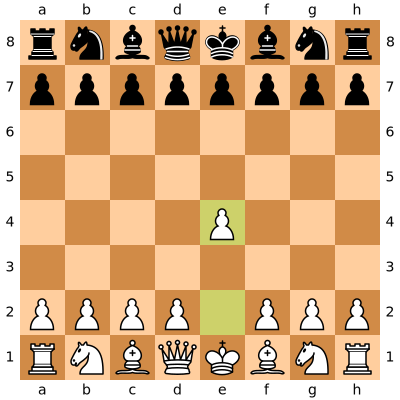

In [75]:
position.parent.board()

In [66]:
move_str

'g5f3'

In [67]:
tensor2move(move_tensor)

'g5f3'

In [57]:
for x, y in keras_generator():
    break

In [58]:
tensor2move(x[0])

'b8d8'

In [48]:
x.shape

(32, 8, 8, 12)

In [49]:
y.shape

(32, 8, 8, 81)

In [53]:
y.max()

1.0

In [290]:
x.sum(axis=(1,2,3))

array([18.,  7.,  7., 28.,  5., 28., 12., 31.,  7., 13., 15.,  9.,  7.,
       31., 18.,  7.])

In [61]:
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D
import keras

inp = Input(shape=(8, 8, 1))
conv_1 = Conv2D(10, (3,3), padding='same')(inp)
conv_1 = Activation('relu')(conv_1)


conv_2 = Conv2D(8, (3,3), padding='same')(conv_1)

result = Activation('sigmoid')(conv_2)


model = Model(inputs=inp, outputs=result)

In [62]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 8, 8, 1)           0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 8, 8, 10)          100       
_________________________________________________________________
activation_40 (Activation)   (None, 8, 8, 10)          0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 8, 8, 8)           728       
_________________________________________________________________
activation_41 (Activation)   (None, 8, 8, 8)           0         
Total params: 828
Trainable params: 828
Non-trainable params: 0
_________________________________________________________________


In [58]:
8000 * 9 / (20*60)

60.0

In [24]:
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D
import keras

inp = Input(shape=(8, 8, 12))
conv_1 = Conv2D(512, (3,3), padding='same')(inp)
conv_1 = Conv2D(512, (3,3), padding='same')(conv_1)
conv_1 = Activation('relu')(conv_1)

conv_2 = Conv2D(256, (3,3), padding='same')(conv_1)
conv_2 = Conv2D(256, (3,3), padding='same')(conv_2)
conv_2 = Activation('relu')(conv_2)

conv_3 = Conv2D(128, (3,3), padding='same')(conv_2)
conv_3 = Conv2D(128, (3,3), padding='same')(conv_3)
conv_3 = Activation('relu')(conv_3)

conv_4 = Conv2D(81, (3,3), padding='same')(conv_3)
conv_4 = Conv2D(81, (3,3), padding='same')(conv_4)
result = Activation('sigmoid')(conv_4)


model = Model(inputs=inp, outputs=result)

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 8, 8, 12)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 512)         55808     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 512)         2359808   
_________________________________________________________________
activation_5 (Activation)    (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 256)         1179904   
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 256)         590080    
_________________________________________________________________
activation_6 (Activation)    (None, 8, 8, 256)         0         
__________

In [26]:
best_w = keras.callbacks.ModelCheckpoint('best_all.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('last_all.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [ ]:
batch_size = 16
model.fit_generator(keras_generator(),
              steps_per_epoch=20000,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(),
              validation_steps=2000,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
  813/20000 [>.............................] - ETA: 10:06 - loss: 0.0722

In [27]:
game.board()

NameError: name 'game' is not defined

In [23]:
import chess.uci

engine = chess.uci.popen_engine("../stockfish-10-linux/Linux/stockfish_10_x64")
engine.uci()

# Synchronous mode.
board = chess.Board("1k1r4/pp1b1R2/3q2pp/4p3/2B5/4Q3/PPP2B2/2K5 b - - 0 1")
engine.position(board)
engine.go(movetime=2000)

BestMove(bestmove=Move.from_uci('d6d1'), ponder=Move.from_uci('c1d1'))

In [25]:
engine.name

'Stockfish 10 64'

In [28]:
board = chess.Board()

In [687]:
board.push(chess.Move.from_uci('b8d7'))

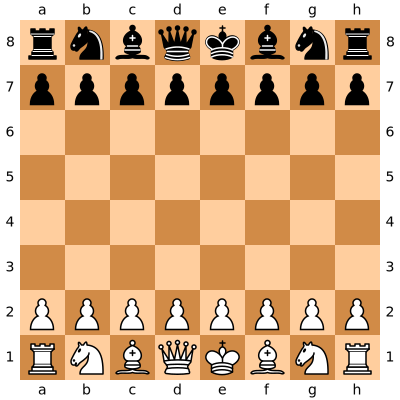

In [29]:
board

In [31]:
#position = get_position(game, 80)
white_ohe = ohe_board(board, white=True)
black_ohe = ohe_board(board, white=False)

feat_tensor = np.concatenate([white_ohe, black_ohe], axis=-1)

ohe = np.expand_dims(feat_tensor, axis=0)
pred = model.predict(ohe)

print('{} : {}'.format(tensor2move(pred[0]), pred[0].max()))

UnboundLocalError: local variable 'move_to_str' referenced before assignment

In [308]:
(pred[0] == 0.27716219425201416).max()

True

In [311]:
tensor2move((1 - (pred[0] == 0.27716219425201416) ) * pred[0])

'c3d2'

In [111]:
pred[0].max()

0.97227097

In [112]:
tensor2move(pred[0])

'g1f3'